# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
from typing import Iterable, Union

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [4]:
# >80% of the columns are categorical or ordinal, meaning that statistics 
#   like mean and stddev don't have much meaning
feat_info.groupby('type').count()

,attribute,information_level,missing_or_unknown
type,,,
categorical,21,21,21
interval,1,1,1
mixed,7,7,7
numeric,7,7,7
ordinal,49,49,49


In [5]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [6]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [7]:
def count_rows_containining_nan(df):
    return len(df[df.isna().any(axis=1)])

original_nan_count = count_rows_containining_nan(azdias)
print(f'Total of {original_nan_count} rows containing NaN or None')

Total of 628074 rows containing NaN or None


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [8]:
# convert '[1,2,"foo"]' to ["1","2","foo"]
def parse_array_from_col(df, col_name: str):
    return df[col_name] \
        .map(lambda s: s[1:-1]) \
        .map(lambda s: [i for i in s.split(',') if i != '']) # split comma-separated string

unknown_vals = parse_array_from_col(feat_info, 'missing_or_unknown')
unknown_vals.head()

0       [-1, 0]
1    [-1, 0, 9]
2       [-1, 0]
3           [0]
4          [-1]
Name: missing_or_unknown, dtype: object

In [9]:
# type info of objects in series of arrays
def types_in_series_of_arrays(series):
    to_types_fn = lambda arr: list(map(lambda i: type(i), arr)) # gross
    return list(series.map(to_types_fn)) 

types_in_series_of_arrays(unknown_vals)[50:60]

[[str], [], [str, str], [], [str], [str], [str], [str, str], [str], [str, str]]

We want to convert these to ints, but we need to check for non-numeric data first:

In [10]:
# replacement for isnumeric, which doesn't work with negative numbers
def isnum(s: str) -> bool: 
    try: 
        float(s)
        return True
    except:
        return False

# which of these are non-numric?
def print_rows_containing_nonnum(df):
    for i, v in df.items():
        if any(not isnum(s) for s in v):
            print(f'{i}: {v}')

print_rows_containing_nonnum(unknown_vals)

57: ['-1', 'X']
58: ['XX']
59: ['-1', 'XX']


In [11]:
# Which columns are these?
for idx in [57, 58, 59]:
    print(azdias.columns[idx])

CAMEO_DEUG_2015
CAMEO_DEU_2015
CAMEO_INTL_2015


In [12]:
# does our dataframe actually contain 'X' or 'XX' anywhere? (yes)
len(azdias[(azdias.values == 'X') | (azdias.values == 'XX')])

1119

In [13]:
# methods to help convert numeric data to numbers
def safeint(s: str) -> Union[int,str]: 
    try: 
        return int(s)
    except:
        return s
    
def test_safeint(values: Iterable[str]):
    for v in values:
        sv = safeint(v)
        print(f"Type for {sv}: {type(sv)} (originally '{v}')")

test_safeint(['0', '1', '-1', '100', 'X', 'XX'])

Type for 0: <class 'int'> (originally '0')
Type for 1: <class 'int'> (originally '1')
Type for -1: <class 'int'> (originally '-1')
Type for 100: <class 'int'> (originally '100')
Type for X: <class 'str'> (originally 'X')
Type for XX: <class 'str'> (originally 'XX')


In [14]:
# Now that we know we have non-numeric values in missing_or_unknown, let's attempt to convert to int where possible
unknown_vals = unknown_vals.map(lambda arr: [safeint(s) for s in arr])
unknown_vals.head()

0       [-1, 0]
1    [-1, 0, 9]
2       [-1, 0]
3           [0]
4          [-1]
Name: missing_or_unknown, dtype: object

In [15]:
# should expect some int, some str
types_in_series_of_arrays(unknown_vals)[50:60]

[[int], [], [int, int], [], [int], [int], [int], [int, str], [str], [int, str]]

In [16]:
# now let's handle the missing_or_unknown values.
def replace_values_with_na(df_origin, series_unknown_value_arrays):
    df = df_origin.copy()
    for idx, unknowns in series_unknown_value_arrays.items():
        to_replace = series_unknown_value_arrays[idx]
        if to_replace: # skip empty arrays
            df.iloc[:,idx] = df.iloc[:,idx].replace(to_replace=to_replace, value=np.NaN)
    return df

In [17]:
azdias_v2 = replace_values_with_na(azdias, unknown_vals)
azdias_v2.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,205378.000000,888340.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,793846.000000,793947.000000,793846.000000
mean,1.743410,2.757217,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.166686,5.293389,3.071033
std,0.674312,1.009951,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,0.999072,2.303379,1.360532
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.000000
50%,2.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.000000
75%,2.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.000000
max,3.000000,4.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,5.000000,9.000000,5.000000


In [18]:
azdias_v2.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [19]:
# Let's confirm none of the unknown values exist in respective columns
for idx, unknowns in unknown_vals.items():
    to_replace = unknown_vals[idx]
    if to_replace:
        assert not any(azdias_v2.iloc[:,idx].isin(to_replace))

print('Passed.')

Passed.


In [20]:
# should be equal or greater number of NaN
found = count_rows_containining_nan(azdias_v2)
assert found >= original_nan_count
print(f'Passed. Originally found {original_nan_count} rows containing NaN or None, now {found}.')

Passed. Originally found 628074 rows containing NaN or None, now 891078.


In [21]:
# Previously 1119
assert len(azdias_v2[(azdias_v2.values == 'X') | (azdias_v2.values == 'XX')]) == 0
print('Passed.')

Passed.


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [22]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
nan_col_counts = azdias_v2.isna().sum().sort_values(ascending=False)
nan_col_counts

TITEL_KZ                 889061
AGER_TYP                 685843
KK_KUNDENTYP             584612
KBA05_BAUMAX             476524
GEBURTSJAHR              392318
ALTER_HH                 310267
REGIOTYP                 158064
KKK                      158064
W_KEIT_KIND_HH           147988
KBA05_ANTG4              133324
KBA05_GBZ                133324
MOBI_REGIO               133324
KBA05_ANTG1              133324
KBA05_ANTG2              133324
KBA05_ANTG3              133324
PLZ8_GBZ                 116515
PLZ8_HHZ                 116515
PLZ8_BAUMAX              116515
PLZ8_ANTG4               116515
PLZ8_ANTG1               116515
PLZ8_ANTG3               116515
PLZ8_ANTG2               116515
SHOPPER_TYP              111196
VERS_TYP                 111196
HEALTH_TYP               111196
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
KBA13_ANZAHL_PKW         105800
ANZ_HAUSHALTE_AKTIV       99611
CAMEO_INTL_2015           99352
                          ...  
RETOURTY

(array([ 57.,  22.,   0.,   2.,   1.,   1.,   1.,   0.]),
 array([     0, 100000, 200000, 300000, 400000, 500000, 600000, 700000,
        800000]),
 <a list of 8 Patch objects>)

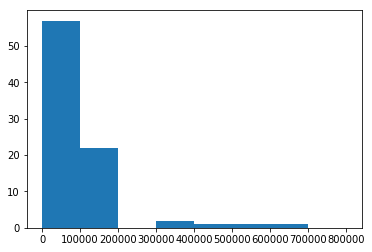

In [23]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(x=nan_col_counts,bins=range(0,900000,100000))

In [24]:
COL_CUTOFF=300000
nan_col_counts[nan_col_counts >= COL_CUTOFF]

TITEL_KZ        889061
AGER_TYP        685843
KK_KUNDENTYP    584612
KBA05_BAUMAX    476524
GEBURTSJAHR     392318
ALTER_HH        310267
dtype: int64

In [25]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
colnames_to_drop = nan_col_counts[nan_col_counts >= COL_CUTOFF].index.values
azdias_v3 = azdias_v2.drop(colnames_to_drop, axis=1)
len(azdias_v3.columns)

79

In [26]:
azdias_v3.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [27]:
# NOTE: over 80% of original columns are nominal or ordinal, meaning that statistics like
#       mean and stddev don't have mathematical meaning. HOWEVER, they are still useful,
#       as they can help us identify important shifts between two datasets.
def delta_desc(df1, df2):
    df1_desc = df1.describe()
    df2_desc = df2.describe()
    df = pd.DataFrame(columns=['column', 'mean', 'Δ mean', '% mean change', 'std', 'Δ std', '% std change'])
    for col in df2.columns.values : # use df2; columns may have been removed
        try:
            mean_delta = abs(df1_desc[col].loc["mean"] - df2_desc[col].loc["mean"])
            mean_percent = 100.0 * mean_delta / df2_desc[col].loc["mean"]
            std_delta = abs(df1_desc[col].loc["std"] - df2_desc[col].loc["std"])
            std_percent = 100.0 * std_delta / df2_desc[col].loc["std"]
            dict_vals = {'column': col, 'mean': df2_desc[col].loc['mean'], 'Δ mean': mean_delta, 
                    '% mean change':mean_percent, 'std': df2_desc[col].loc['std'], 
                    'Δ std': std_delta, '% std change': std_percent}
            df = df.append(dict_vals, ignore_index=True)
        except KeyError:
            print(f'Skipping {col}')
    return df.sort_values(by=['% mean change', '% std change'], ascending=False)

# so far, how do all of these changes impact our remaining data columns
deltas = delta_desc(azdias, azdias_v3)
deltas.head(n=15)

Skipping OST_WEST_KZ
Skipping CAMEO_DEUG_2015
Skipping CAMEO_DEU_2015
Skipping CAMEO_INTL_2015


,column,mean,Δ mean,% mean change,std,Δ std,% std change
38,VERS_TYP,1.511166,0.313314,20.733234,0.499876,0.452656,90.553736
36,SHOPPER_TYP,1.590134,0.323166,20.323210,1.027972,0.259463,25.240290
12,HEALTH_TYP,2.190129,0.398026,18.173657,0.755213,0.513849,68.040229
19,NATIONALITAET_KZ,1.168889,0.142061,12.153551,0.475075,0.111558,23.482277
20,PRAEGENDE_JUGENDJAHRE,9.280709,1.126363,12.136608,4.032107,0.812425,20.148908
13,LP_LEBENSPHASE_FEIN,16.332161,1.709523,10.467222,12.242378,0.374505,3.059087
14,LP_LEBENSPHASE_GROB,4.955185,0.501563,10.121992,3.748974,0.106665,2.845185
15,LP_FAMILIE_FEIN,3.922339,0.322764,8.228871,3.941285,0.014799,0.375493
16,LP_FAMILIE_GROB,2.381976,0.196010,8.228871,1.701527,0.055010,3.232991
43,W_KEIT_KIND_HH,4.147141,0.213735,5.153780,1.784211,0.180490,10.115929


In [28]:
# no change to mean and stddev (presumably no data was removed)
len(deltas[(deltas['% mean change'] == 0.0) & (deltas['% std change'] == 0.0)])

58

#### Discussion 1.1.2: Assess Missing Data in Each Column

## Removing Columns
Over 90% (79 out of 85) of columns have less than 20% missing data. The six columns that exceeded 20% missing data are:

| Column Name | Missing Rows | % Missing |
| ----------- | ------------ | --------- |
| TITEL_KZ | 889061 | 99.8% |
| AGER_TYP | 685843 | 77.0% |
| KK_KUNDENTYP | 584612 | 65.6% |
| KBA05_BAUMAX | 476524 | 53.5% |
| GEBURTSJAHR | 392318 | 44.0% |
| ALTER_HH | 310267 | 34.8%  |

These columns were removed from the dataset.

## Replacing Missing Data with NaN

Besides removing columns missing above 20% of their data, swapping numeric placeholders for missing data with NaN changed data as well. Out of 79 remaining columns, 7 columns had >10% change to their mean as a result of this operation:

| Column Name | % Mean Change | % Std Change |
| ----------- | ------------- | ------------ |
| VERS_TYP | 20.733234 | 90.553736 |
| SHOPPER_TYP | 20.323210 | 25.240290 |
| HEALTH_TYP | 18.173657 | 68.040229 |
| NATIONALITAET_KZ | 12.153551 | 23.482277 |
| PRAEGENDE_JUGENDJAHRE | 12.136608 | 20.148908 |
| LP_LEBENSPHASE_FEIN | 10.467222 | 3.059087 |
| LP_LEBENSPHASE_GROB | 10.121992	 | 2.845185 |

Important caveat: mean and standard deviation do not have mathematical meaning for most of the columns (which are ordinal or categorical); however, they help us identify shifts in the data, flagging columns where we should expect to see significant differences in the data, regardless of the data type.

Not all columns were impacted by this operation; it appears that 58 of 79 remaining columns have no change to mean or standard deviation, presumably because no data was removed from these columns.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [29]:
# How much data is missing in each row of the dataset?
nan_row_counts = azdias_v3.isna().sum(axis=1).sort_values(ascending=False)
nan_row_counts.head()

643174    49
732775    49
472919    48
183108    47
139316    47
dtype: int64

(array([  6.97109000e+05,   7.76340000e+04,   1.28010000e+04,
          9.53300000e+03,   8.29000000e+02,   1.55000000e+02,
          1.40160000e+04,   5.03100000e+03,   2.80380000e+04,
          4.60750000e+04]),
 array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50]),
 <a list of 10 Patch objects>)

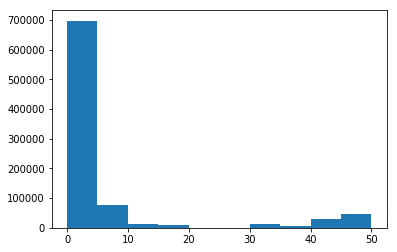

In [30]:
plt.hist(x=nan_row_counts,bins=range(0,51,5))

In [31]:
ROW_CUTOFF = 30
above_cutoff_rows = nan_row_counts[nan_row_counts >= ROW_CUTOFF]
print(f'With cutoff of {ROW_CUTOFF}, would lose {len(above_cutoff_rows)} of {len(nan_row_counts)} ' \
      f'rows. ({100 * len(above_cutoff_rows) / len(nan_row_counts):.2f}%)')

With cutoff of 30, would lose 93160 of 891221 rows. (10.45%)


In [32]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
below_idxs = nan_row_counts[nan_row_counts < ROW_CUTOFF].index.values
above_idxs = above_cutoff_rows.index.values
azdias_v4 = azdias_v3[azdias_v3.index.isin(below_idxs)]
discarded_rows = azdias_v3[azdias_v3.index.isin(above_idxs)]

In [33]:
# sample discarded rows
discarded_rows.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,2.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,3.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,2.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,3.0,2,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
# how many cells were missing for this sample?
discarded_rows.head().isna().sum(axis=1)

0     43
11    47
14    47
17    47
24    47
dtype: int64

In [35]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# NOTE: Even though we're going to look at categorical data (for which summary statistics like 'mean'
#   and 'stddev' do not have meaning), we'll use these aggregate statistics to find the columns with
#   the largest shifts between these datasets.
deltas = delta_desc(discarded_rows, azdias_v4)
deltas.head(n=15)

Skipping OST_WEST_KZ
Skipping CAMEO_DEUG_2015
Skipping CAMEO_DEU_2015
Skipping CAMEO_INTL_2015


,column,mean,Δ mean,% mean change,std,Δ std,% std change
11,GREEN_AVANTGARDE,0.219563,0.219563,100.000000,0.413951,0.413951,100.000000
46,ANZ_HH_TITEL,0.040647,0.040647,100.000000,0.324030,0.324030,100.000000
7,FINANZ_UNAUFFAELLIGER,2.658348,2.064645,77.666445,1.399530,0.658387,47.043436
6,FINANZ_ANLEGER,2.840955,1.840357,64.779538,1.472782,0.596283,40.486828
24,SEMIO_REL,3.994567,2.353780,58.924539,1.910502,0.387458,20.280425
43,W_KEIT_KIND_HH,4.161731,2.423689,58.237518,1.778825,1.061908,59.697171
26,SEMIO_VERT,4.277355,2.426517,56.729395,1.945580,0.048262,2.480577
42,HH_EINKOMMEN_SCORE,4.413475,2.406216,54.519775,1.545246,1.453548,94.065759
31,SEMIO_KRIT,4.549570,2.043926,44.925691,1.760368,0.427213,24.268398
22,SEMIO_SOZ,4.139783,1.855175,44.813354,1.940929,0.994949,51.261489


In [36]:
def plot_two_hist(series1, series2, range1=None, range2=None, title1=None, title2=None):
    _, axes = plt.subplots(1, 2)
    series1.hist(bins=range1, ax=axes[0])
    series2.hist(bins=range2, ax=axes[1])
    axes[0].title.set_text(title1)
    axes[1].title.set_text(title2)

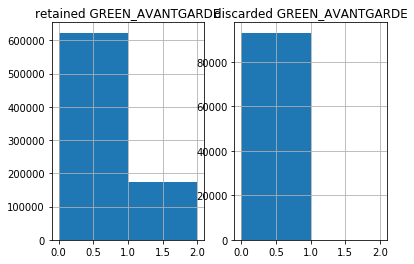

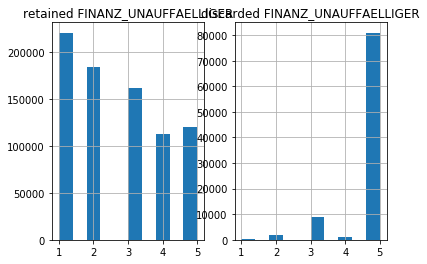

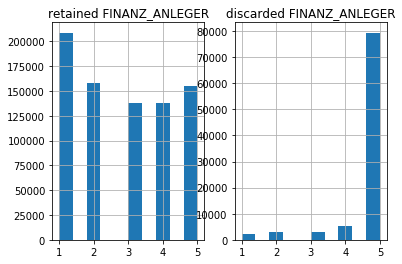

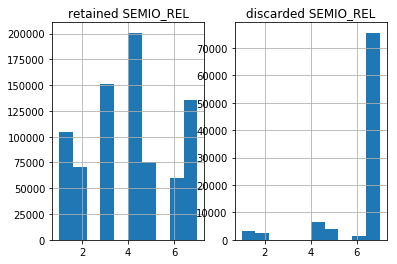

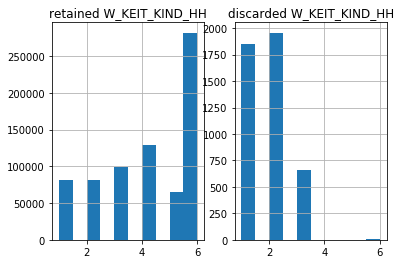

In [37]:
# skipping ANZ_HH_TITEL; graphs difficult to distinguish
cols = [
    ('GREEN_AVANTGARDE', [0,1,2]),
    ('FINANZ_UNAUFFAELLIGER', None),
    ('FINANZ_ANLEGER', None),
    ('SEMIO_REL', None),
    ('W_KEIT_KIND_HH', None)
]
for col in cols:
    col_name, range_ = col
    series1 = azdias_v4[col_name]
    series2 = discarded_rows[col_name]
    plot_two_hist(
        series1,
        series2,
        range1 = range_,
        range2 = range_,
        title1=f'retained {col_name}', 
        title2=f'discarded {col_name}'
    )

In [38]:
# interesting; it appears that the discarded data doesn't contain any '1' category data
discarded_rows['GREEN_AVANTGARDE'].sum()

0

In [39]:
# let's look at columns with low changes in mean
deltas.dropna().tail(n=15)

,column,mean,Δ mean,% mean change,std,Δ std,% std change
37,SOHO_KZ,0.008417,0.000281,3.335905,0.091355,0.001500,1.642398
14,LP_LEBENSPHASE_GROB,4.946719,0.146840,2.968437,3.742719,0.104458,2.790959
40,ANZ_PERSONEN,1.728850,0.050451,2.918208,1.156529,0.029692,2.567343
72,ARBEIT,3.166687,0.083354,2.632212,0.999070,0.165430,16.558381
13,LP_LEBENSPHASE_FEIN,16.310959,0.367675,2.254162,12.222719,0.331622,2.713164
9,FINANZTYP,3.797751,0.068543,1.804837,2.084705,1.330197,63.807460
47,GEBAEUDETYP,2.798642,0.048642,1.738056,2.656716,0.093870,3.533306
19,NATIONALITAET_KZ,1.168530,0.014969,1.281051,0.474722,0.014323,3.017179
49,MIN_GEBAEUDEJAHR,1993.276776,15.639891,0.784632,3.332144,2.427565,72.852950
63,REGIOTYP,4.472086,0.027914,0.624189,1.836358,0.284962,15.517806


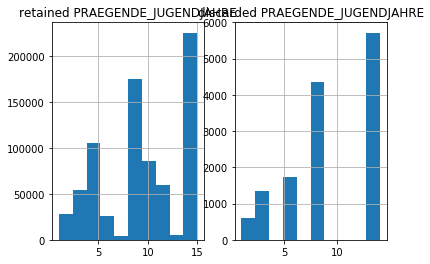

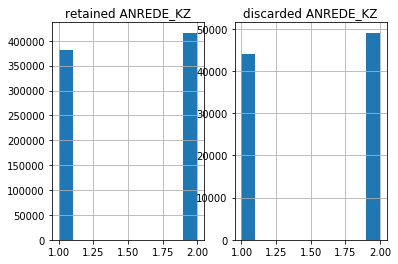

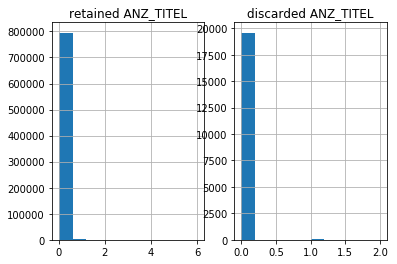

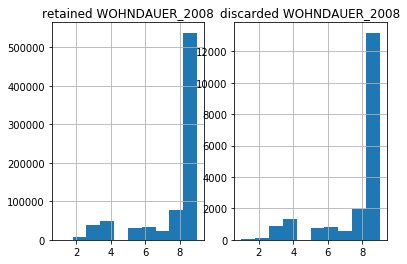

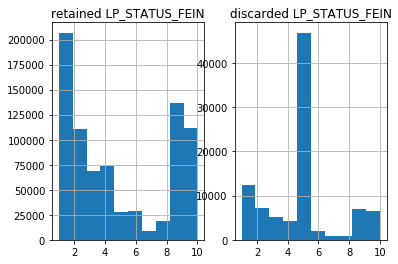

In [40]:
cols = [
    ('PRAEGENDE_JUGENDJAHRE', None),
    ('ANREDE_KZ', None),
    ('ANZ_TITEL', None),
    ('WOHNDAUER_2008', None),
    ('LP_STATUS_FEIN', None)
]
for col in cols:
    col_name, range_ = col
    series1 = azdias_v4[col_name]
    series2 = discarded_rows[col_name]
    plot_two_hist(
        series1,
        series2,
        range1 = range_,
        range2 = range_,
        title1=f'retained {col_name}', 
        title2=f'discarded {col_name}'
    )

In [41]:
feat_info[feat_info['attribute'] == 'LP_STATUS_FEIN']

,attribute,information_level,type,missing_or_unknown
19,LP_STATUS_FEIN,person,categorical,[0]


Note that `LP_STATUS_FEIN` has a low mean difference; however, the data distributions are quite different. This is a categorical dataset. This underscores the dangers of using something like mean with categorical or ordinal data. (Or even exclusively relying on mean for any data type.)

In [42]:
# how many columns have greater than 10% change?
len(deltas[deltas['% mean change'] >= 10.0])

33

#### Discussion 1.1.3: Assess Missing Data in Each Row

I set the cutoff for retaining a row to less than 30 missing values; when I graphed a histogram of the number of missing values, it appeared to form two separate distributions. I retained data from the distribution with less missing values, which accounts for 89.55% of the data.

I then rank ordered the columns by the percentage change in the mean between the two classes of rows. These columns are categorical, so calculating statistics like the mean and standard deviation doesn't have any meaning; however, it helps identify columns with significant changes. And indeed, the difference between these two datasets is quite large; in fact, it is much larger than when we swapped in NaN values.

Skipping `ANZ_HH_TITEL` (because it is hard to visually interpret this graph), I plotted the other top five columns, based on the aforementioned sort. In each case, the distributions were very different. 

E.g., for `GREEN_AVANTGARDE`, the retained data contained both categories `0` and `1`; but the discarded data exclusively contained `0`.

E.g., for `FINANZ_UNAUFFAELLIGER`, the mode of the retained data is `1`, but for the discarded data the mode is `5`.

Unsurprisingly, for many of the columns with low mean differences, we see that data is similar between the two datasets. However, as we saw with `LP_STATUS_FEIN` (a categorical dataset), we see that a low mean doesn't always imply similar datasets. This suggests that with our analysis, we are underrepresenting the differences between these datasets.

33 of 79 (42%) of columns have a greater than 10% change in the mean. (Again, most columns are categorical or ordinal, so a 10% change in mean doesn't have mathematical meaning, but helps us identify dissimilar datasets.) This represents a large fraction of the data columns; these two datasets appear to represent at least least two different segments.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [43]:
# Let's filter out the columns no longer in our dataset
feat_info_v4 = feat_info[feat_info['attribute'].isin(azdias_v4.columns.values)]

# How many features are there of each data type?
feat_info_v4.groupby('type').count()

,attribute,information_level,missing_or_unknown
type,,,
categorical,18,18,18
mixed,6,6,6
numeric,6,6,6
ordinal,49,49,49


In [44]:
categorical_cols = feat_info_v4[feat_info_v4['type'] == 'categorical']['attribute']
mixed_cols = feat_info_v4[feat_info_v4['type'] == 'mixed']['attribute']
assert len(categorical_cols + mixed_cols) == 24
#categorical_mixed_cols = feat_info_v4[feat_info_v4['type'].isin(['categorical', 'mixed'])]['attribute']
#assert len(categorical_mixed_cols) == 24
print('Passed.')

Passed.


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [45]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
binary_numeric = []
binary_non_numeric = []
multi_level = []

for col_name in categorical_cols:
    groupby_cnts = azdias_v4.groupby(col_name)[col_name].count()
    has_non_numeric = False in list(map(isnum, groupby_cnts.index.values))
    is_binary = len(groupby_cnts) == 2
    
    if is_binary and has_non_numeric:
        binary_non_numeric.append(col_name)
    
    elif is_binary:
        binary_numeric.append(col_name)
    
    else:
        multi_level.append(col_name)

In [46]:
print(f'{len(binary_numeric)} binary non-numeric, {len(binary_non_numeric)} binary numeric, {len(multi_level)} multi-level')
print(f'{len(feat_info_v4)} total columns')

4 binary non-numeric, 1 binary numeric, 13 multi-level
79 total columns


In [47]:
binary_non_numeric

['OST_WEST_KZ']

In [48]:
azdias_v4['OST_WEST_KZ'].unique()

array(['W', 'O'], dtype=object)

In [49]:
# Re-encode categorical variable(s) to be kept in the analysis.
azdias_v5 = azdias_v4.copy()

azdias_v5['OST_WEST_KZ'] = azdias_v4['OST_WEST_KZ'].replace({'W': 1, 'O': 2})

# remove multi-level categorical (to keep things straightforward)
azdias_v5 = azdias_v5.drop(multi_level, axis=1)

# sanity check
assert len(azdias_v5.columns.values) == len(azdias_v4.columns.values) - len(multi_level)

# shouldn't be any remaining non-numeric data
for col_name in azdias_v5.columns.values:
    assert not False in list(map(isnum, azdias_v5[col_name].values))

print('Passed.')
print(f'Our dataset now has {len(azdias_v5.columns.values)} columns.')

Passed.
Our dataset now has 66 columns.


#### Discussion 1.2.1: Re-Encode Categorical Features

There were a total of 18 categorical datasets. Of these, 5 were binary, and 13 were multi-level categorical.

To keep the analysis simpler, I discarded the multi-level categorical variables. (Time permitting, I would have performed one-hot encoding and included them.)

Of the binary data, one contained non-numeric data; so I replaced the non-numeric values with numeric values (`0`, `1`).

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [50]:
# Let's filter out the columns no longer in our dataset
feat_info_v5 = feat_info[feat_info['attribute'].isin(azdias_v5.columns.values)]

# How many features are there of each data type?
feat_info_v5.groupby('type').count()

,attribute,information_level,missing_or_unknown
type,,,
categorical,5,5,5
mixed,6,6,6
numeric,6,6,6
ordinal,49,49,49


In [51]:
feat_info_v5[feat_info_v5['type'] == 'mixed']

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [52]:
def isint(s) -> bool: 
    try: 
        int(s)
        return True
    except:
        return False

azdias_v6 = azdias_v5.copy()

# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias_v6['decade'] = azdias_v6['PRAEGENDE_JUGENDJAHRE'].replace({
    1: 40, 2: 40, 3: 50, 4: 50, 5: 60, 6: 60, 7: 60, 8: 70, 9: 70, 10: 80, 11: 80, 12: 80, 13: 80, 14: 90, 15: 90
})

azdias_v6['movement'] = azdias_v6['PRAEGENDE_JUGENDJAHRE'].isin([2, 4, 6, 7, 9, 11, 13, 15])

azdias_v6 = azdias_v6.drop('PRAEGENDE_JUGENDJAHRE', axis=1)

# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_v6['affluence'] = azdias_v6['CAMEO_INTL_2015'].apply(lambda a: 6 - int(int(a) / 10) if isint(a) else np.NaN)

azdias_v6['lifestyle'] = azdias_v6['CAMEO_INTL_2015'].apply(lambda a: int(a) % 10 if isint(a) else np.NaN)

azdias_v6 = azdias_v6.drop('CAMEO_INTL_2015', axis=1)

# Investigate "WOHNLAGE"
azdias_v6['neighborhood_quality'] = azdias_v6['WOHNLAGE'].replace({
    0: np.NaN, 1: 1, 2: 1, 3: 1, 4: 0, 5: 0, 7: np.NaN, 8: np.NaN
})

azdias_v6['rural'] = azdias_v6['WOHNLAGE'].replace({
    0: np.NaN, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 7: 1, 8: 1
})

azdias_v6 = azdias_v6.drop('WOHNLAGE', axis=1)

# Investigate 'PLZ8_BAUMAX'
azdias_v6['mostly_single_family_homes'] = azdias_v6['PLZ8_BAUMAX'].apply(lambda a: 1 if a == 1 else 0)

azdias_v6 = azdias_v6.drop('PLZ8_BAUMAX', axis=1)

# Dropping columns overlapping w/ poverty and lifestyle
azdias_v6 = azdias_v6.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB'], axis=1)

#### Discussion 1.2.2: Engineer Mixed-Type Features

From the mixed data types, I created the following features:
* decade
* movement
* affluence
* lifestyle
* neighborhood_quality
* rural
* mostly_single_family_homes

I ended up dropping all of the original columns after extracting these features; I believe I extracted the most useful features from these original datasets.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [53]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [54]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [99]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    df_copy = df.copy()

    # replace unknown values with np.NaN
    df_copy = replace_values_with_na(df_copy, unknown_vals)

    # drop columns with too many NaN
    #nan_col_counts = df_copy.isna().sum().sort_values(ascending=False)
    colnames_to_drop = nan_col_counts[nan_col_counts >= COL_CUTOFF].index.values
    assert len(colnames_to_drop) == 6
    df_copy = df_copy.drop(colnames_to_drop, axis=1)

    # drop rows with too many NaN
    nan_row_counts = df_copy.isna().sum(axis=1).sort_values(ascending=False)
    below_idxs = nan_row_counts[nan_row_counts < ROW_CUTOFF].index.values
    df_copy = df_copy[df_copy.index.isin(below_idxs)]

    # re-encode OST_WEST_KZ (non-numeric binary categorical data)
    df_copy['OST_WEST_KZ'] = df_copy['OST_WEST_KZ'].replace({'W': 1, 'O': 2})

    # remove multi-level categorical (to keep things straightforward)
    df_copy = df_copy.drop(multi_level, axis=1)

    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    df_copy['decade'] = df_copy['PRAEGENDE_JUGENDJAHRE'].replace({
        1: 40, 2: 40, 3: 50, 4: 50, 5: 60, 6: 60, 7: 60, 8: 70, 9: 70, 10: 80, 11: 80, 12: 80, 13: 80, 14: 90, 15: 90
    })

    df_copy['movement'] = df_copy['PRAEGENDE_JUGENDJAHRE'].isin([2, 4, 6, 7, 9, 11, 13, 15])

    df_copy = df_copy.drop('PRAEGENDE_JUGENDJAHRE', axis=1)

    # Investigate "CAMEO_INTL_2015" and engineer two new variables.
    df_copy['affluence'] = df_copy['CAMEO_INTL_2015'].apply(lambda a: 6 - int(int(a) / 10) if isint(a) else np.NaN)

    df_copy['lifestyle'] = df_copy['CAMEO_INTL_2015'].apply(lambda a: int(a) % 10 if isint(a) else np.NaN)

    df_copy = df_copy.drop('CAMEO_INTL_2015', axis=1)

    # Investigate "WOHNLAGE"
    df_copy['neighborhood_quality'] = df_copy['WOHNLAGE'].replace({
        0: np.NaN, 1: 1, 2: 1, 3: 1, 4: 0, 5: 0, 7: np.NaN, 8: np.NaN
    })

    df_copy['rural'] = df_copy['WOHNLAGE'].replace({
        0: np.NaN, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 7: 1, 8: 1
    })

    df_copy = df_copy.drop('WOHNLAGE', axis=1)

    # Investigate 'PLZ8_BAUMAX'
    df_copy['mostly_single_family_homes'] = df_copy['PLZ8_BAUMAX'].apply(lambda a: 1 if a == 1 else 0)

    df_copy = df_copy.drop('PLZ8_BAUMAX', axis=1)

    # Dropping columns overlapping w/ poverty and lifestyle
    df_copy = df_copy.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB'], axis=1)
    
    assert len(df_copy.columns.values) == 67, f'{len(df_copy.columns.values)} != 67'

    return df_copy

In [100]:
azdias_clean = clean_data(azdias)
assert azdias_clean.equals(azdias_v6)
print('Passed.')

Passed.


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [57]:
# yikes
print(f'{count_rows_containining_nan(azdias_clean)} out of {len(azdias_clean)} rows contain missing data.')

311793 out of 798061 rows contain missing data.


In [58]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

# perform imputation, using most frequent value
imputer = Imputer(strategy='most_frequent')
azdias_imputed = pd.DataFrame(
    data=imputer.fit_transform(azdias_clean), 
    index=azdias_clean.index.values,
    columns=azdias_clean.columns.values
)

In [59]:
assert count_rows_containining_nan(azdias_imputed) == 0
print('Passed.')

Passed.


In [60]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
azdias_scaled = pd.DataFrame(
    data=scaler.fit_transform(azdias_imputed), 
    index=azdias_imputed.index.values,
    columns=azdias_imputed.columns.values
)

In [61]:
# cool
azdias_scaled.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,ARBEIT,ORTSGR_KLS9,RELAT_AB,decade,movement,affluence,lifestyle,neighborhood_quality,rural,mostly_single_family_homes
count,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,...,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05
mean,-5.235178e-18,-4.195710e-17,-1.162868e-16,1.379843e-16,1.217268e-16,-6.495004e-17,-1.572512e-16,-1.217980e-16,-3.712703e-18,-1.577409e-16,...,9.856024e-17,-1.341114e-16,1.085320e-17,1.530844e-16,-3.712703e-18,-1.821628e-17,7.614157e-17,-6.219000e-17,2.740455e-17,6.780802e-17
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.766646e+00,-1.043935e+00,-1.494594e+00,-1.155518e+00,-1.766980e+00,-1.249985e+00,-1.184933e+00,-1.501377e+00,-5.304094e-01,-1.633796e+00,...,-2.174897e+00,-1.868057e+00,-1.525981e+00,-2.316552e+00,-5.304094e-01,-1.175657e+00,-1.248894e+00,-1.671689e+00,-5.527839e-01,-1.293628e+00
25%,-7.830616e-01,-1.043935e+00,-7.686810e-01,-1.155518e+00,-1.040692e+00,-1.249985e+00,-1.184933e+00,-7.912046e-01,-5.304094e-01,-3.118160e-01,...,-1.714001e-01,-5.622952e-01,-7.890268e-01,-9.507027e-01,-5.304094e-01,-1.175657e+00,-1.248894e+00,-1.671689e+00,-5.527839e-01,-1.293628e+00
50%,2.005224e-01,9.579144e-01,-4.276828e-02,1.912029e-01,4.118838e-01,1.079899e-01,-4.704071e-01,-8.103182e-02,-5.304094e-01,-3.118160e-01,...,-1.714001e-01,-1.270413e-01,-5.207229e-02,4.151461e-01,-5.304094e-01,-4.938777e-01,9.509872e-02,5.981974e-01,-5.527839e-01,7.730199e-01
75%,1.184106e+00,9.579144e-01,6.831445e-01,8.645632e-01,1.138172e+00,7.869776e-01,9.586455e-01,6.291410e-01,-5.304094e-01,1.010164e+00,...,8.303485e-01,7.434664e-01,6.848823e-01,1.098070e+00,-5.304094e-01,8.696800e-01,7.670949e-01,5.981974e-01,-5.527839e-01,7.730199e-01
max,1.184106e+00,9.579144e-01,1.409057e+00,1.537924e+00,1.138172e+00,1.465965e+00,1.673172e+00,1.339314e+00,1.885336e+00,1.010164e+00,...,1.832097e+00,1.613974e+00,1.421837e+00,1.098070e+00,1.885336e+00,1.551459e+00,1.439091e+00,5.981974e-01,1.809025e+00,7.730199e-01


### Discussion 2.1: Apply Feature Scaling

I used an imputer with "most frequent" strategy. I didn't choose mean because many of the data types are categorical or ordinal, so 2.1752 doesn't make sense. (Similarly, a value of 1 and 3 averages to 2, but that doesn't make sense for these data types.)

Similarly, using a "median" strategy doesn't make sense if the data isn't ordered, which is frequently the case.

Imputing does introduce the risk of making it harder to cluster these datasets. For example, perhaps a row should belong to a cluster because it represents an individual that belong to a specific segment. However, if this row is missing values for the most important features, then imputing the wrong value could result in misclassification.

I used the standard scaler because it was recommended; I'm honestly not sure know standardization should be used as opposed to (say) normalization. However, I would choose a standardization method over something like logarithmic transformation, so that the values would be closely related.

One benefit of standardization over normalization is that standardization preserves outlying datapoints. If I use standardization, the data points will always be in range [0, 1]. If any columns have distributions with greater variance, that information is lost.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [62]:
def explore_variance(df, min_variance):
    max_n = len(df.columns.values)
    print(f'Will try n ∈ [1, 2, ..., {max_n-1}]')
    variances = []
    for n in range(1, max_n):
        pca = PCA(n)
        _ = pca.fit(df)
        variance = sum(pca.explained_variance_ratio_)
        print(f'PCA with {n} found variance of {variance}')
        print(f'\tPrincipal component variance: {pca.explained_variance_ratio_[0]}')
        variances.append(variance)
        if variance >= min_variance:
            return variances
    raise Exception(f"Couldn't find enough components with {min_variance} variance")

Will try n ∈ [1, 2, ..., 66]
PCA with 1 found variance of 0.1710239447945973
	Principal component variance: 0.1710239447945973
PCA with 2 found variance of 0.2995210292950389
	Principal component variance: 0.171023944794605
PCA with 3 found variance of 0.39027832051807243
	Principal component variance: 0.1710239447946018
PCA with 4 found variance of 0.44329675838792715
	Principal component variance: 0.17102394479460173
PCA with 5 found variance of 0.47886458426080786
	Principal component variance: 0.17102394479460992
PCA with 6 found variance of 0.5097012247292405
	Principal component variance: 0.1710239447946081
PCA with 7 found variance of 0.5374758120321181
	Principal component variance: 0.17102394476991
PCA with 8 found variance of 0.5630667629293451
	Principal component variance: 0.1710239447676717
PCA with 9 found variance of 0.5859772344660047
	Principal component variance: 0.17102394476874572
PCA with 10 found variance of 0.6075587991006889
	Principal component variance: 0.1710

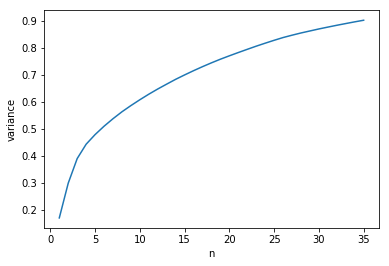

In [63]:
# find variances
variances = explore_variance(azdias_scaled, .90)

# plot
max_n = range(1, len(variances) + 1)
plt.plot(max_n, variances);
plt.xlabel('n');
plt.ylabel('variance');

In [64]:
# Re-apply PCA to the data while selecting for number of components to retain.
num_components = 35
pca = PCA(n_components=num_components)
X_pca = pca.fit_transform(azdias_scaled)

### Discussion 2.2: Perform Dimensionality Reduction

Given how much data I had to impute, I'm nervous about further degrading the quality of the data. Therefore, I decided to pick n based on capturing at least 90% of the variance of the data, which n=35 in this case.

There's an inflection point at n=4, which captures 44% of the variance. However, until I uncover performance problems, I'll try a much higher n with the hopes of getting better performance.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [65]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def analyze_component(comp_idx: int):
    col_cnt = len(azdias_scaled.columns.values)
    col_range = range(0, col_cnt)
    feature_variance = list(map(lambda col_idx: (azdias_scaled.columns.values[col_idx], pca.components_[comp_idx][col_idx]), col_range))
    feature_variance.sort(key=lambda t: abs(t[1]), reverse=True)
    
    # print top 10
    for idx in range(0, 10):
        tup = feature_variance[idx]
        print(f'* {tup[0]}: {tup[1]}')

for comp_idx in range(0, 5):
    print(f'Component #{comp_idx+1}')
    analyze_component(comp_idx)
    print()

Component #1
* PLZ8_ANTG3: 0.228656675012887
* PLZ8_ANTG1: -0.22776131512870793
* MOBI_REGIO: -0.22031224972503674
* PLZ8_ANTG4: 0.21840431765305215
* mostly_single_family_homes: -0.21497328509681632
* KBA05_GBZ: -0.21225765967771149
* KBA05_ANTG1: -0.2093068362112043
* ORTSGR_KLS9: 0.204386213408723
* affluence: -0.20151674973083764
* FINANZ_MINIMALIST: -0.20138937017139852

Component #2
* ALTERSKATEGORIE_GROB: 0.2696045622633763
* SEMIO_REL: -0.26477423987778453
* decade: -0.2507368002998142
* FINANZ_SPARER: -0.24942246816911973
* FINANZ_VORSORGER: 0.24255658593399168
* SEMIO_PFLICHT: -0.23876202738447885
* SEMIO_TRADV: -0.23796003834766033
* SEMIO_ERL: 0.2349996594781355
* FINANZ_UNAUFFAELLIGER: -0.23329261663218748
* SEMIO_KULT: -0.22381647446310954

Component #3
* ANREDE_KZ: -0.36848420718435404
* SEMIO_VERT: 0.3468168475136894
* SEMIO_KAEM: -0.33719474307519975
* SEMIO_DOM: -0.31336679782248583
* SEMIO_KRIT: -0.2770514466507707
* SEMIO_SOZ: 0.26190597770266305
* SEMIO_FAM: 0.2491

### Discussion 2.3: Interpret Principal Components

| Component | Variance | Short Description | Long Description |
| --------- | -------- | ----------------- | ---------------- |
| 0 | 0.17 | densly-populated area | Positively associated with housing holding 8-10 families and large number of buildings; and negatively associated with single family dwellings. |
| 1 | 0.13 | younger | Positively associated with going to events; negatively associated with age, religious affinity, saving, traditional values. | 
| 2 | 0.09 | right-brained | Positively associated with being a dreamer, socially-/family-/culturally-minded; negatively associated with aggressiveness, dominant-/critical-/rational-minded, or investing| 
| 3 | 0.05 | urban liberal | Positively associated with high income, population density, participating in environmental groups; negatively associated rural areas | 

Though there were cases where I wasn't sure about the interpretation (e.g., strong positive male association with the "right-brained" component), for the most part these components mapped to intuitive demographics.

I'm least confident in the "right-brained" component, and I know that "right-brained" is not a scientifically accurate description; but the idea is that there are more creative, collective individuals that are not as rational, individualistic, or dominant. 

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

* n=1 score=48186614.83082411
* n=2 score=41297416.01226773
* n=3 score=38150574.58350918
* n=4 score=35917556.921364896
* n=5 score=34437818.39147335
* n=6 score=33199848.012271002
* n=7 score=32067170.195435274
* n=8 score=31202408.216868706
* n=9 score=30562429.092108816
* n=10 score=29803270.40089294
* n=11 score=29440077.63352808
* n=12 score=28782275.325923223
* n=13 score=28453771.63382576
* n=14 score=28029200.233005118
* n=15 score=27783328.674683295


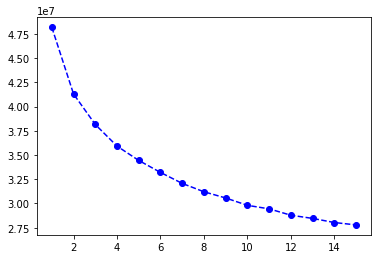

In [66]:
def score_k(n):
    k = KMeans(n)
    m = k.fit(X_pca)
    score = -m.score(X_pca)
    print(f"* n={n} score={score}")
    return score

centers = range(1, 16)
scores = list(map(score_k, centers))

plt.plot(centers, scores, linestyle='--', marker='o', color='b')

In [67]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(4)
fitted_kmeans = kmeans.fit(X_pca)
azdias_clusters = fitted_kmeans.predict(X_pca)

### Discussion 3.1: Apply Clustering to General Population

After calculating n for {1..15} and graphing the results, using the elbow method I selected n=4 as the MSE decreases start to drop.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [70]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';') 

In [101]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_clean = clean_data(customers)

customers_imputed = pd.DataFrame(
    data=imputer.transform(customers_clean), 
    index=customers_clean.index.values,
    columns=customers_clean.columns.values
)

customers_scaled = pd.DataFrame(
    data=scaler.transform(customers_imputed), 
    index=customers_imputed.index.values,
    columns=customers_imputed.columns.values
)

customers_pca = pca.transform(customers_scaled)

customes_clusters = fitted_kmeans.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

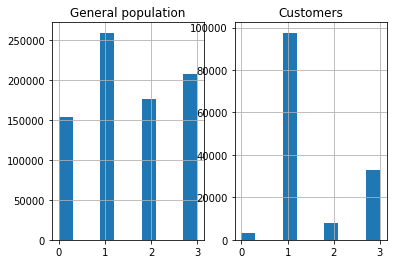

In [106]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

azdias_clusters_ = pd.Series(azdias_clusters)
customes_clusters_ = pd.Series(customes_clusters)

plot_two_hist(
    azdias_clusters_,
    customes_clusters_,
    title1=f'General population', 
    title2=f'Customers'
)

In [107]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
def cluster_features(cluster_idx):
    features = []
    for idx in range(0, num_components):
        features.append((idx, fitted_kmeans.cluster_centers_[cluster_idx][idx]))
    features.sort(key=lambda t: abs(t[1]), reverse=True)
    return features

cluster_features(0)[0:10]

[(0, 4.3312105002502204),
 (1, -1.9683065929060963),
 (2, -0.29230662106915833),
 (3, 0.15235576635553227),
 (11, 0.14125880138550648),
 (15, 0.11086663782219051),
 (13, -0.10765676580319238),
 (6, -0.10319674218951816),
 (9, 0.079284046372132322),
 (19, 0.06652864719386814)]

In [108]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

cluster_features(1)[0:10]

[(0, -3.4152387006382079),
 (1, 1.1252090025194661),
 (2, 0.26835333365092651),
 (3, 0.15827277237682247),
 (4, 0.14095006108217714),
 (13, -0.10464576231344726),
 (7, 0.085459199458679302),
 (6, 0.072843651079009142),
 (18, 0.060664370852901918),
 (22, -0.058191546157427894)]

In [109]:
cluster_features(2)[0:10]

[(1, -3.4275523854791428),
 (0, -1.2836405564808431),
 (2, -0.74683249282844455),
 (4, -0.12669552724234434),
 (18, -0.10971444244691454),
 (19, -0.10797430213512227),
 (8, -0.10206319956229493),
 (17, 0.099667490748773013),
 (10, -0.097503292670742911),
 (5, 0.092302176087406887)]

### Discussion 3.3: Compare Customer Data to Demographics Data

For our customers, mapping the first three clusters to our top four components:

| Component | Cluster 1 | Cluster 2 | Cluster 3 |
| --------- | --------- | --------- | --------- |
| 0. densely-populated | 4.33 | -3.42 | -1.28 |
| 1. younger | -1.96 | 1.13 | -3.43 |
| 2. right-brained | -0.292 | 0.27 | -0.75 |
| 3. urban liberal | 0.15 | 0.19 | -0.13 |

Our customer base has a disproportionately low ratio of clusters 1 & 3, and a disportionately high ratio of cluster 2, relative to the general population. 

This tells us that our customers are:

* generally younger
* live in less densely-populated areas

To a much lesser extent, the customers tend to be more "right-brained", meaning more associated with analytic and individualistism.

The first two components are most strongly related to the first two components.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.